In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys

# Data

Source: https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [2]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip

--2021-07-08 19:32:12--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com... 2a00:1450:4010:c02::80, 2a00:1450:4010:c1e::80, 2a00:1450:4010:c0d::80, ...
Connecting to storage.googleapis.com|2a00:1450:4010:c02::80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: 'jena_climate_2009_2016.csv.zip.5'

jena_climate_2009_2 100%[===================>]  12.94M  3.97MB/s    in 3.3s    

2021-07-08 19:32:18 (3.97 MB/s) - 'jena_climate_2009_2016.csv.zip.5' saved [13568290/13568290]



In [3]:
from zipfile import ZipFile

zip_file = ZipFile("jena_climate_2009_2016.csv.zip")
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

In [4]:
data = pd.read_csv(csv_path)
data = data.iloc[::200] # only each 200th point

data.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0    01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   93.30   
200  02.01.2009 09:30:00    998.53     -3.90    269.38        -4.84   93.10   
400  03.01.2009 18:50:00    995.37     -3.87    269.65       -10.69   58.83   
600  05.01.2009 04:10:00    985.44     -1.77    272.53        -3.22   89.70   
800  06.01.2009 13:30:00    996.63    -11.09    262.32       -15.74   68.25   

     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0            3.33          3.11          0.22       1.94             3.12   
200          4.57          4.26          0.32       2.66             4.27   
400          4.59          2.70          1.89       1.69             2.71   
600          5.36          4.81          0.55       3.04             4.88   
800          2.61          1.78          0.83       1.11             1.79   

     rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0         1307.75      1.03           1.75    152.30  
200       1289.77      1.42           1.88    180.80  
400       1286.30      1.73           2.38    243.60  
600       1262.57      3.11           5.63    260.90  
800       1323.90      1.10           2.00     19.56

In [5]:
data.shape

(2103, 15)

# Visualisation

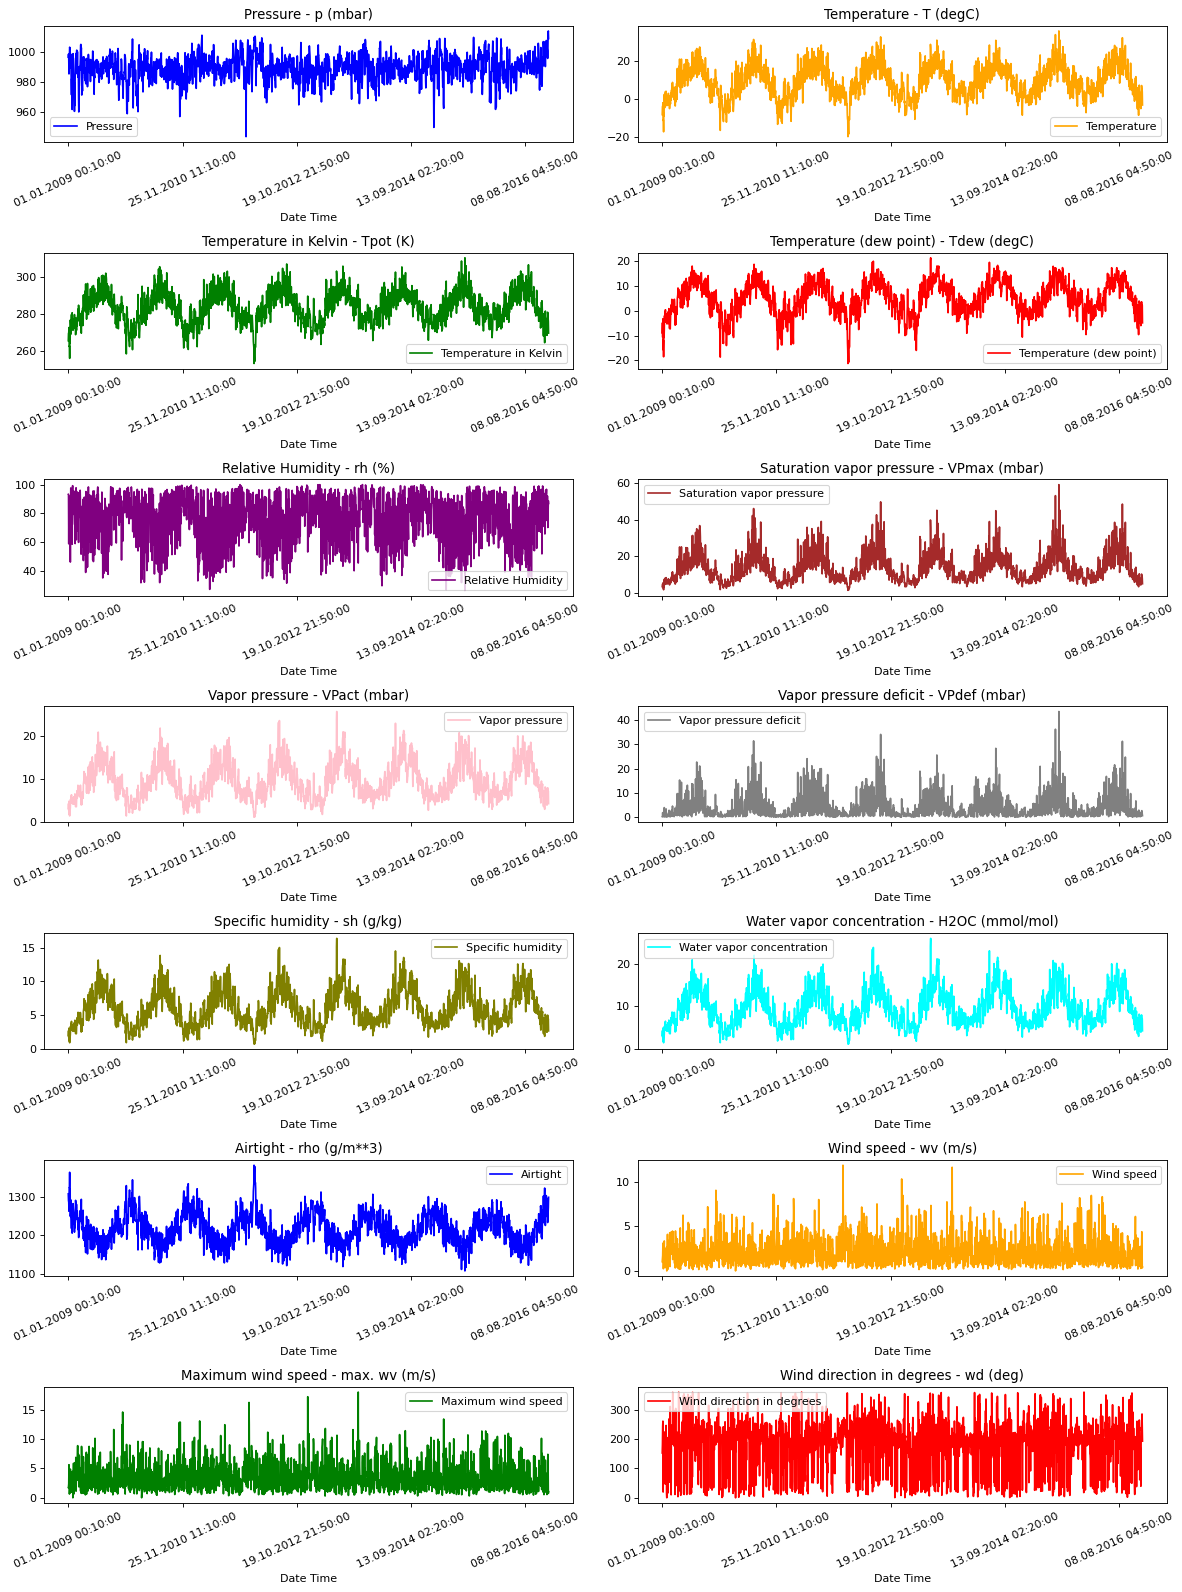

In [6]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(ax=axes[i // 2, i % 2], color=c, title="{} - {}".format(titles[i], key), rot=25,)
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(data)

# Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
X = data[["T (degC)"]].values
#X = data[feature_keys[1:-1]].values

ss = StandardScaler()
X = ss.fit_transform(X)

# AR model for time series forecast

Consider $y_1, y_2, ..., y_i, ..., y_N$ are observations of a time series. Autoregressive Model for the time series forecast assumes the following:

$$ \hat{y}_{i+m} = f( y_{i}, y_{i-1}, ... y_{i-k+1} ) $$

where $\hat{y}_{i+m}$ is a predicted value.

In matrix forms we will define this model as:

$$\hat{Y} = f(X)$$

where
$$X = \left(
\begin{array}{cccc}
y_{k} & y_{k-1} & \ldots & y_{1}\\
\vdots & \vdots & \ddots & \vdots\\
y_{k+j} & y_{k+j-1} & \ldots & y_{j+1}\\
\vdots & \vdots & \ddots & \vdots
\end{array}
\right)$$

$$Y = \left(
\begin{array}{c}
y_{k+m} \\
\vdots\\
y_{k+j+m}\\
\vdots
\end{array}
\right)$$

In [9]:
def AR_matrices(Y, k, m):
    X_AR = []
    Y_AR = []
    for i in range(len(Y)):
        
        if i < k-1: continue
        if i+m >= len(Y): break
        
        ax_ar = Y[i+1-k:i+1].reshape(-1, )
        X_AR.append(ax_ar)

        ay_ar = Y[i+m]#[0]
        Y_AR.append(ay_ar)

    return np.array(X_AR), np.array(Y_AR)

In [10]:
# prepare X and Y matrices
X_AR, Y_AR = AR_matrices(X, k=10, m=10)

## Train / test split

In [11]:
N = len(X)//2

X_AR_train, X_AR_test = X_AR[:N], X_AR[N:]
Y_AR_train, Y_AR_test = Y_AR[:N], Y_AR[N:]

## Fit Conditional WGAN model

In [12]:
import wgan

In [13]:
latent_dim = Y_AR_train.shape[1]

generator     = wgan.Generator(n_inputs=latent_dim+X_AR_train.shape[1], 
                               n_outputs=Y_AR_train.shape[1])
discriminator = wgan.Discriminator(n_inputs=Y_AR_train.shape[1]+X_AR_train.shape[1])

In [14]:
%%time

model = wgan.Fitter(generator, discriminator, batch_size=50, n_epochs=1000, latent_dim=latent_dim, lr=0.0001, n_critic=5)
model.fit(Y_AR_train, X_AR_train) # data, condition

CPU times: user 1min 4s, sys: 2.18 s, total: 1min 6s
Wall time: 1min 9s


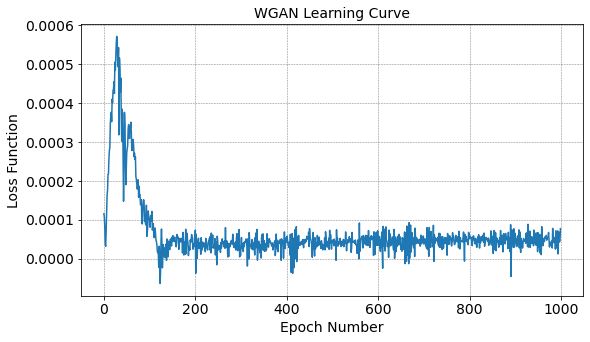

In [15]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(model.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Make single prediction

In [16]:
Y_pred_train = model.predict(X_AR_train)
Y_pred_test  = model.predict(X_AR_test)

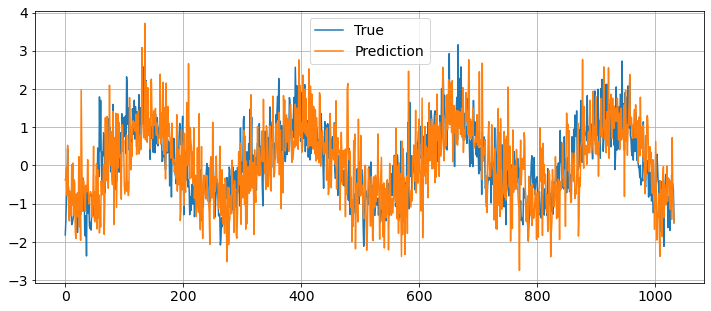

In [17]:
for i in range(Y_AR_test.shape[1]):
    plt.figure(figsize=(12, 5))
    plt.plot(Y_AR_test[:, i], label='True', alpha=1.)
    plt.plot(Y_pred_test[:, i], label='Prediction', alpha=1.)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1)
    #plt.xlim(0, 200)
    plt.show()

# Make several predictions

In [18]:
N_preds = 100

predictions_test = []
for i in range(N_preds):
    Y_pred_test = model.predict(X_AR_test)
    # store predictions
    predictions_test.append(Y_pred_test)
predictions_test = np.array(predictions_test)

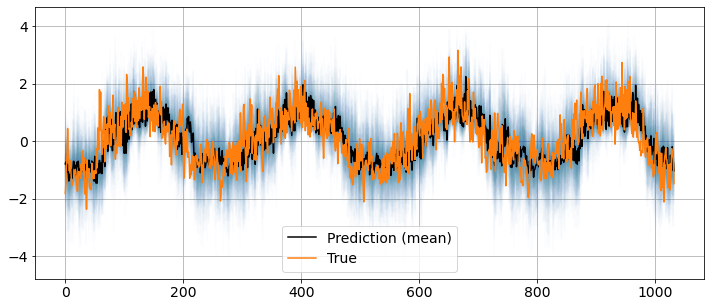

In [19]:
for i in range(Y_AR_test.shape[1]):

    plt.figure(figsize=(12, 5))
    for Y_pred_test in predictions_test:
        plt.plot(Y_pred_test[:, i], alpha=0.01, color='C0')
    plt.plot(predictions_test.mean(axis=0)[:, i], label='Prediction (mean)', alpha=1., color='0')
    plt.plot(Y_AR_test[:, i], label='True', alpha=1., color='C1')
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1)
    #plt.xlim(150, 200)
    #plt.ylim(0, 2)
    plt.show()

# Quality metrics

In [20]:
#!pip install properscoring

In [21]:
import metrics

In [22]:
# меньше - лучше, [0, +inf]
mu, std = metrics.crps_score(Y_AR_test, predictions_test)
print("CRPS = %.3f +- %.3f" % (mu, std))

CRPS = 0.352 +- 0.026


In [23]:
# меньше - лучше, [~0, 1]
mu, std = metrics.discrepancy_score(Y_AR_test, predictions_test, model='QDA')
print("DS_QDA = %.3f +- %.3f" % (mu, std))

DS_QDA = -0.025 +- 0.003


In [24]:
# меньше - лучше, [~0, 1]
mu, std = metrics.discrepancy_score(Y_AR_test, predictions_test, model='RF')
print("DS_RF = %.3f +- %.3f" % (mu, std))

DS_RF = 0.090 +- 0.003


In [25]:
# меньше - лучше, [~0, 1]
mu, std = metrics.discrepancy_score(Y_AR_test, predictions_test, model='DT')
print("DS_DT = %.3f +- %.3f" % (mu, std))

DS_DT = 0.062 +- 0.004


# Experiments

In [26]:
def experiemnt(cols=["T (degC)"]):
    
    # take data
    X = data[cols].values

    # scaling
    ss = StandardScaler()
    X = ss.fit_transform(X)
    
    # prepare X and Y matrices
    X_AR, Y_AR = AR_matrices(X, k=10, m=10)
    
    # train / test split
    N = len(X)//2
    X_AR_train, X_AR_test = X_AR[:N], X_AR[N:]
    Y_AR_train, Y_AR_test = Y_AR[:N], Y_AR[N:]
    
    # define gnerator and discriminator
    latent_dim = Y_AR_train.shape[1]
    generator     = wgan.Generator(n_inputs=latent_dim+X_AR_train.shape[1], 
                                   n_outputs=Y_AR_train.shape[1])
    discriminator = wgan.Discriminator(n_inputs=Y_AR_train.shape[1]+X_AR_train.shape[1])
    
    # fit model
    model = wgan.Fitter(generator, discriminator, batch_size=50, n_epochs=1000, latent_dim=latent_dim, lr=0.0001, n_critic=5)
    model.fit(Y_AR_train, X_AR_train) # data, condition
    
    # make predictions
    N_preds = 100
    predictions_test = []
    for i in range(N_preds):
        Y_pred_test = model.predict(X_AR_test)
        # store predictions
        predictions_test.append(Y_pred_test)
    predictions_test = np.array(predictions_test)
    
    # quality metrics calculation
    mu, std = metrics.crps_score(Y_AR_test, predictions_test)
    print("CRPS = %.3f +- %.3f" % (mu, std))
    
    mu, std = metrics.discrepancy_score(Y_AR_test, predictions_test, model='QDA')
    print("DS_QDA = %.3f +- %.3f" % (mu, std))
    
    # меньше - лучше, [~0, 1]
    mu, std = metrics.discrepancy_score(Y_AR_test, predictions_test, model='DT')
    print("DS_DT = %.3f +- %.3f" % (mu, std))

In [27]:
experiemnt(cols=["T (degC)"])

CRPS = 0.364 +- 0.028
DS_QDA = 0.074 +- 0.003
DS_DT = 0.066 +- 0.004


In [28]:
experiemnt(cols=["rh (%)"])

CRPS = 0.498 +- 0.038
DS_QDA = 0.047 +- 0.004
DS_DT = 0.029 +- 0.004


In [29]:
experiemnt(cols=["VPdef (mbar)"])

CRPS = 0.396 +- 0.050
DS_QDA = 0.028 +- 0.005
DS_DT = 0.046 +- 0.003


In [30]:
experiemnt(cols=["wv (m/s)"])

CRPS = 0.548 +- 0.052
DS_QDA = 0.003 +- 0.005
DS_DT = 0.022 +- 0.004


In [31]:
cols = ["T (degC)", "rh (%)", "VPdef (mbar)", "wv (m/s)"]
experiemnt(cols)

CRPS = 0.457 +- 0.042
DS_QDA = 0.494 +- 0.002
DS_DT = 0.194 +- 0.004


In [32]:
cols = feature_keys[1:-1]
experiemnt(cols)

CRPS = 0.408 +- 0.037
DS_QDA = 0.985 +- 0.000
DS_DT = 0.287 +- 0.005
